### VGG2 aligner: single core test<br>

In [18]:
import sys, os, argparse
import sys
sys.path.append("../") # root for the ...
from   tqdm import tqdm
import cv2
import dlib
from PIL import Image

import numpy as np # used by hopenet

#from gele_fast_image_recognition.gele_aligner.transform_align import transform_align 
from transform_align import transform_align 
# if you use: from YourClassParentDir.YourClass import YourClass   # means Class YourClass
# or use YourClass.YourClass(), it works
# or use YourClass.YourClass(), it works


import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.backends.cudnn as cudnn
import torchvision
import torch.nn.functional as F

import matplotlib.pyplot as plt



In [19]:
flag_gpu_available = torch.cuda.is_available()

if flag_gpu_available:
    torch_device = torch.device("cuda")
    print('================= cuda available ==================')
else:
    torch_device = torch.device("cpu")
    print('================= using CPU ==================')

================= using CPU ==================


### 1.Clean Duplicates

In [4]:
def pHash(cv_image):
    imgg = cv2.cvtColor(cv_image, cv2.COLOR_BGR2GRAY);
    h=cv2.img_hash.pHash(imgg) # 8-byte hash
    pH=int.from_bytes(h.tobytes(), byteorder='big', signed=False)
    return pH

def plot_image(img,xlabel=''):
    fig, axes = plt.subplots(1, 1, figsize=(9, 3), dpi=128)
    ax = axes; ax.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB));ax.set_xticks([]);ax.set_yticks([])
    ax.set_xlabel(xlabel)

# https://www.pyimagesearch.com/2020/04/20/detect-and-remove-duplicate-images-from-a-dataset-for-deep-learning/
def dhash(image, hashSize=8):
    # convert the image to grayscale and resize the grayscale image,
    # adding a single column (width) so we can compute the horizontal
    # gradient
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    resized = cv2.resize(gray, (hashSize + 1, hashSize))
    # compute the (relative) horizontal gradient between adjacent
    # column pixels
    diff = resized[:, 1:] > resized[:, :-1]
    # convert the difference image to a hash and return it
    #print(diff)
    return sum([2 ** i for (i, v) in enumerate(diff.flatten()) if v])

In [6]:
import os
import glob # file folders/names scan
import time
# base folder, my VGG2 layout has VGG-Face2_orig/data/test and  VGG-Face2_orig/data/train folders, which we unite here
dataroot = '/media/expert/4T_Vol0/A_Work/Updated_New/FACEREC/Data/d.VGGFace/VGG-Face2_orig'


Note: My VGG2 version has textual metadata with identities, age, gender. These can be used for training and for filtering the dataset.

In [7]:
print("Loading image paths ...")
start_time = time.time()
train_files = glob.glob(dataroot + "/data/train/*/*")
test_files = glob.glob(dataroot + "/data/test/*/*")
elapsed_time = time.time()-start_time
print("Done! Elapsed time: {:.2f} minutes.".format(elapsed_time/60))
print("Total number of files: {}".format(len(train_files)+len(test_files)))
files = train_files + test_files

Loading image paths ...
Done! Elapsed time: 0.15 minutes.
Total number of files: 3311287


In [9]:
file = files[0] # Test what's inside
print(file)
face_id = os.path.basename(file).split('.')[0] # this is useless - not unique identifier per dta set only per person image
face_label = os.path.basename(os.path.dirname(file))
row = {'id': face_id, 'name': face_label} # face labels are unique per person, but have holes in the numbering (missing numbers)
print(row)


/media/expert/4T_Vol0/A_Work/Updated_New/FACEREC/Data/d.VGGFace/VGG-Face2_orig/data/train/n001950/0241_01.jpg
{'id': '0241_01', 'name': 'n001950'}


In [10]:
# Test duplicates scan, stop at STOP_CNT, because this is test :-)
num_records = len(files)

# See https://stackoverflow.com/questions/45123238/python-class-vs-tuple-huge-memory-overhead/45123561
# install recordclass, allows for reduced memory class type storage of records
# failed to install w conda
#from recordclass import dataobject, make_dataclass
class ImgInstance: # __slots__ based  hashed Image instances storage class
    __slots__ = ['indexes', 'widths']
    def __init__(self, indexes, widths):
        self.indexes = indexes
        self.widths = widths
        
#rem_imgs = list();#rem_imgs.append('test')
STOP_CNT = num_records; 
STOP_CNT = 16000; # Test on limited part of the dataset
cnt = 0
pbar = tqdm(files)
hashes = {} # dictionary (key,value)
duplicates = 0
print("[INFO] computing image hashes...")
ts=time.time() 
for ffname in pbar:
    #filename = str(full_path[i][0])
    #ffname   = os.path.join(photo_dir, filename)
    img = cv2.imread(ffname)
    height, width, channels = img.shape
    cnt = cnt + 1
    h = dhash(img) # pHash(img) # dhash is faster for exact image comparison 
    i_i = hashes.get(h, ImgInstance([],[])) # grab ImgInstance with that hash, if none - create one empty
    #print(p);break
    if len(i_i.indexes) > 0:
        duplicates=duplicates+1
    i_i.indexes.append(ffname)    # add the current ffname
    i_i.widths.append(width) # add the current image width
    
    hashes[h] = i_i        # store the updated object back in the hashes dictionary
    if cnt>= STOP_CNT:
        pbar.update(num_records)
        pbar.close()
        break
dt = (time.time()-ts)
print('Scan done. Found {} duplicates for {} images in {} sec, perf= {} img/sec'.format(duplicates,STOP_CNT,dt,STOP_CNT/dt))



  0%|          | 63/3311287 [00:00<1:33:17, 591.58it/s]

[INFO] computing image hashes...


3327226it [00:25, 128689.23it/s]                          

Scan done. Found 7 duplicates for 16000 images in 25.85528302192688 sec, perf= 618.8290411066478 img/sec


100%|██████████| 15993/15993 [00:00<00:00, 131992.74it/s]


[INFO] 2 paths:
/media/expert/4T_Vol0/A_Work/Updated_New/FACEREC/Data/d.VGGFace/VGG-Face2_orig/data/train/n006714/0397_01.jpg
/media/expert/4T_Vol0/A_Work/Updated_New/FACEREC/Data/d.VGGFace/VGG-Face2_orig/data/train/n006714/0087_01.jpg
[INFO] 2 paths:
/media/expert/4T_Vol0/A_Work/Updated_New/FACEREC/Data/d.VGGFace/VGG-Face2_orig/data/train/n001806/0533_01.jpg
/media/expert/4T_Vol0/A_Work/Updated_New/FACEREC/Data/d.VGGFace/VGG-Face2_orig/data/train/n001806/0097_01.jpg
[INFO] 2 paths:
/media/expert/4T_Vol0/A_Work/Updated_New/FACEREC/Data/d.VGGFace/VGG-Face2_orig/data/train/n005897/0266_01.jpg
/media/expert/4T_Vol0/A_Work/Updated_New/FACEREC/Data/d.VGGFace/VGG-Face2_orig/data/train/n005897/0369_01.jpg
[INFO] 2 paths:
/media/expert/4T_Vol0/A_Work/Updated_New/FACEREC/Data/d.VGGFace/VGG-Face2_orig/data/train/n008577/0035_01.jpg
/media/expert/4T_Vol0/A_Work/Updated_New/FACEREC/Data/d.VGGFace/VGG-Face2_orig/data/train/n008577/0525_01.jpg
[INFO] 2 paths:
/media/expert/4T_Vol0/A_Work/Updated_New

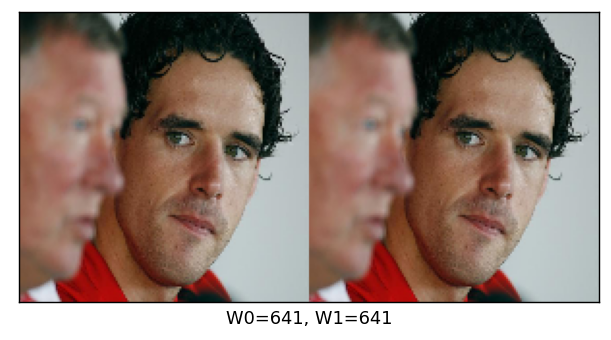

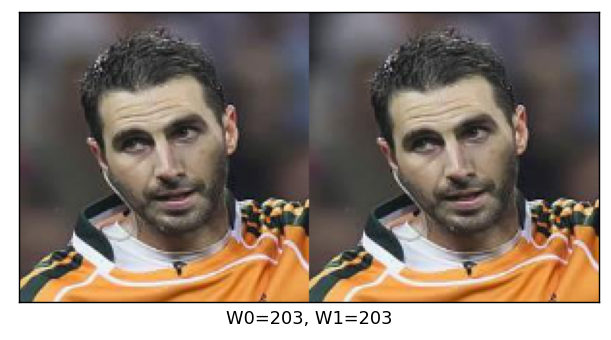

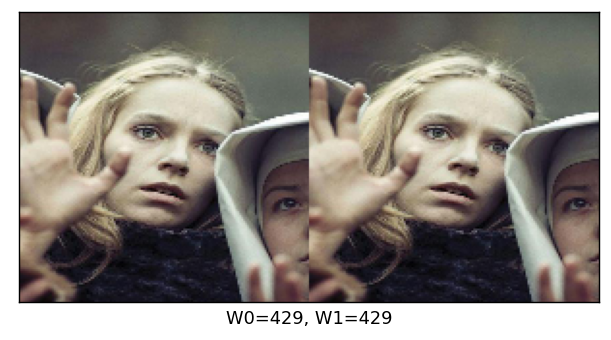

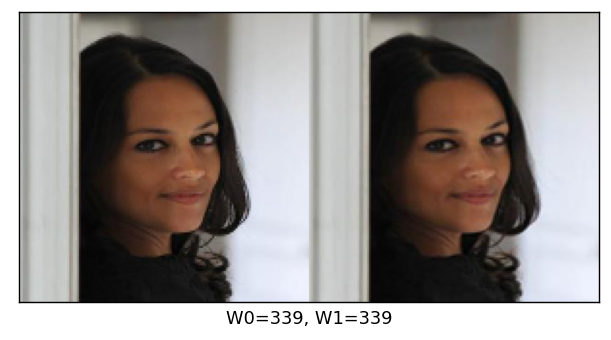

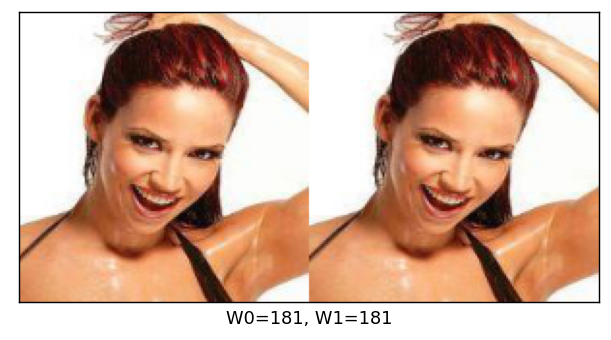

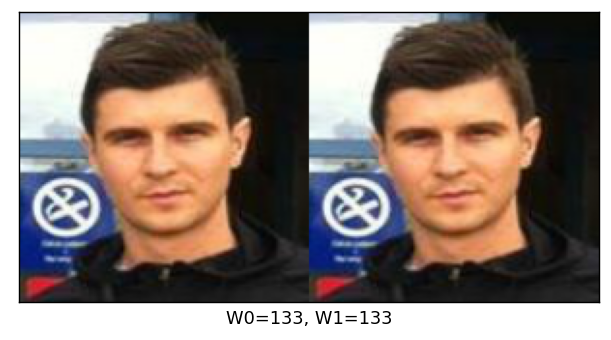

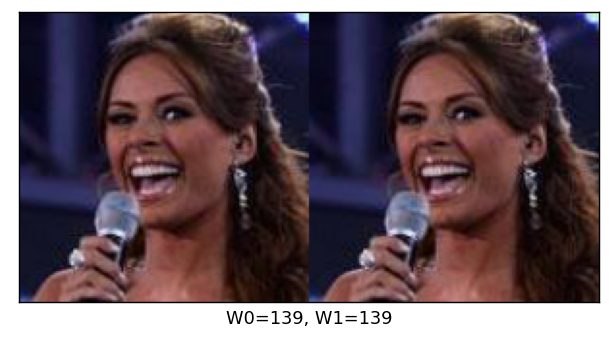

In [11]:
remove=0
pbar = tqdm(hashes.items()) # key, value
for (h, i_i) in pbar: # loop over all image hashes and instances (i_i)
	# check to see if there is more than one image with the same hash
	if len(i_i.indexes) > 1:
		# check to see if this is a dry run
		if remove <= 0:
			# initialize a montage to store all images with the same hash
			montage = None
            #max_w_i = i_i.widths.index(max(i_i.widths))
			# loop over all image paths with the same hash
			for i in i_i.indexes:
				# load the input image and resize it to a fixed width and height
				ffn = i  #os.path.join(photo_dir, full_path[i][0])
				image = cv2.imread(ffn)
				image = cv2.resize(image, (150, 150))
				# if our montage is None, initialize it
				if montage is None:
					montage = image
				# otherwise, horizontally stack the images
				else:
					montage = np.hstack([montage, image])
			# show the montage for the hash
			#print("[INFO] hash: {}".format(h))
			fn1 = i_i.indexes[0]; fn2 = i_i.indexes[1]
			print("[INFO] 2 paths:\n{}\n{}".format(fn1,fn2))
			plot_image(montage,'W0={}, '.format(i_i.widths[0])+'W1={}'.format(i_i.widths[0]))
		else: # otherwise, we'll be removing the duplicate images
			# loop over all image paths with the same hash *except*
			# for the first image in the list (since we want to keep
			# one, and only one, of the duplicate images)
			for p in hashedPaths[1:]:
				#print('removing \'{}\''.format(p))                
				# os.remove(p)
				pass
print('Scan done')
#plot_image(montage)

### STAGE 2 Image size/quality based fitering

In [20]:
import math

def plot_rem_imgs():
    n_cols = 8
    n_rows = math.ceil(STOP_CNT / n_cols)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(24, 12))
    enu = enumerate(rem_imgs)
    for e in enu:
        #ffn = rem_imgs[i];#print(idx)
        ffn=e[1]
        #filename = str(full_path[idx][0]);filename=os.path.join(photo_dir, filename);# print(filename)
        img = cv2.imread(ffn)
        ax = axes.flat[e[0]]
        ax.imshow(img[:, :, [2, 1, 0]]) # BGR -> RGB
        #ax.set_title('P=a:{}, g:{}, r:{}'.format(int(age_pred[img_idx]), ID_GENDER_MAP[gender_pred[img_idx]], ID_RACE_MAP[race_pred[img_idx]]))
        #ax.set_xlabel('T=a:{}, g:{}, r:{}'.format(int(age_race_gender[0][i]), ID_GENDER_MAP[gender_true[i]], ID_RACE_MAP[race_true[i]]))
        xlabel=str(os.stat(ffn).st_size/1024) + ' K'
        ax.set_xlabel(xlabel)
        ax.set_xticks([])
        ax.set_yticks([])
        #age_t = age_true[i] * MAX_AGE
        #gender_t = gender_true[i]
        #gender_t = ID_GENDER_MAP[gender_t.argmax(axis=-1)]
        #race_t = race_true[i]
        #race_t = ID_RACE_MAP[race_t.argmax(axis=-1)]
        #title = 'A:{},G:{},FS={:.2f}'.format(age[idx],gender[idx],face_score[idx])
        title=''
        ax.set_title(title)


  0%|          | 7811/3311287 [00:10<1:11:30, 770.00it/s]


Scan done, found 32 too small images


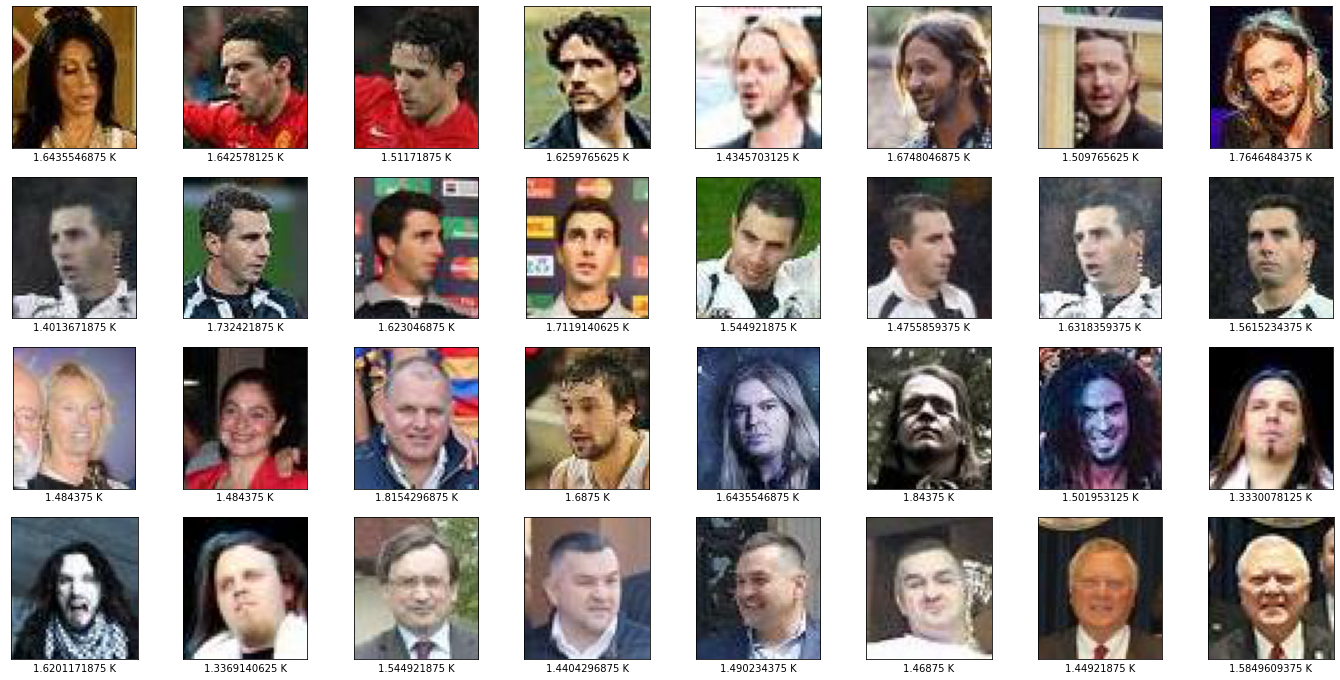

In [21]:
# Form a list of images for removal, based on small size (under 64 px)
rem_imgs = list();#rem_imgs.append('test')
STOP_CNT = 32; MIN_WIDTH = 56; # Say we want better age recognition at price of reduced gender samples
cnt = 0
for ffn in tqdm(files):
    img = cv2.imread(ffn)
    height, width, channels = img.shape
    if width<MIN_WIDTH:
        cnt = cnt + 1
        rem_imgs.append(ffn)
        if cnt>= STOP_CNT:
            break
print('Scan done, found {} too small images'.format(len(rem_imgs)))
plot_rem_imgs() 

In [22]:
# Last stage is to generate a new aligned & cropped VGG2 images
# TODO: think on implementing the MX-net style indexed binary files
target_data_dir = '/media/expert/4T_Vol0/A_Work/Updated_New/FACEREC/Data/d.VGGFace/VGG-Face2_align_crop_224'
if not os.path.exists(target_data_dir):
    os.makedirs(target_data_dir)

In [23]:
# TGT Size:
# James Tameronga ResNet is 224 square. Note: On testing and face feat. eaxtraction, the same transform should be used
TARGET_STRETCHED_SIZE=224
desiredFaceHeight = 448 # set non-equal width, height so the tf_resize stretch the faces, we select bigger than 224 values so we don't lose too much of the image quality
desiredFaceWidth = 352
desiredLeftEye=(0.28, 0.35) 
#TARGET_STRETCHED_SIZE=256 # allow result to be used for 300x300 and smaller size square input networks. not 
#desiredFaceHeight   = 512
#desiredFaceWidth    = 400
# MobileNet uses 192 size:
#TARGET_STRETCHED_SIZE=192
#desiredFaceHeight = 384
#desiredFaceWidth = 304

# openCV predictor weights:
landmark_predictor_weights = './data_weights/shape_predictor_68_face_landmarks.dat'
face_detector_path = './data_weights'

# create explicit instance of our transform_align class, we need it for test later:
tf_align = transform_align(landmark_predictor_weight_path=landmark_predictor_weights, face_detector_path=face_detector_path,
                           desiredFaceWidth=desiredFaceWidth, desiredFaceHeight=desiredFaceHeight,
                           desiredLeftEye=desiredLeftEye)
print(' face aligner created')

 face aligner created


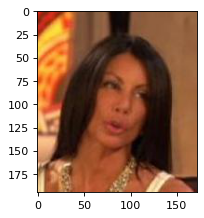

In [24]:
# Get a test image:
test_image_path = files[0]

frame = cv2.imread(test_image_path)
from PIL import Image
pil_img = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
from matplotlib.pyplot import figure
figure(num=None, figsize=(5, 3), dpi=80, facecolor='w', edgecolor='k')
plt.imshow(pil_img)

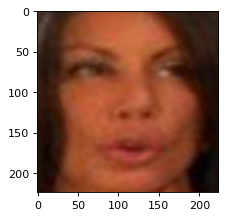

In [25]:
# Align/stretch a test image:
faces, gray_img = tf_align._detect(frame,always_detect=1)
face = faces[0]
a_cv2face = tf_align._align(image=frame, gray=gray_img, rect=face)
resized_cv2 = cv2.resize(a_cv2face, (TARGET_STRETCHED_SIZE, TARGET_STRETCHED_SIZE)) # force non-uniform resize
pil_img = Image.fromarray(cv2.cvtColor(resized_cv2, cv2.COLOR_BGR2RGB))
figure(num=None, figsize=(5, 3), dpi=80, facecolor='w', edgecolor='k')
plt.imshow(pil_img)

In [26]:
# From the "original" VGG2 we will derive ours version:

# Test duplicates scan, stop at STOP_CNT, because this is test :-)
num_records = len(files)

# See https://stackoverflow.com/questions/45123238/python-class-vs-tuple-huge-memory-overhead/45123561
# install recordclass, allows for reduced memory class type storage of records
# failed to install w conda
#from recordclass import dataobject, make_dataclass
class ImgInstance: # __slots__ based  hashed Image instances storage class
    __slots__ = ['indexes', 'widths']
    def __init__(self, indexes, widths):
        self.indexes = indexes # we set here ffns, will consume much memory this way
        self.widths = widths

STOP_CNT = num_records
STOP_CNT = 3200; # !!!!for test!!!!
FORCE_DETECT=0; FACE_DET_PROBABILITY=0.75
MIN_WIDTH = 56    # width filtering ?
cnt = 0; 
duplicates = 0; hashes = {} # dictionary (key,value)
ts = time.time()
for ffn in tqdm(files):
    cv2img = cv2.imread(ffn)
    height, width, channels = cv2img.shape
    
    if width < MIN_WIDTH: # skip too-small
        continue # skip too-small
    
    h = dhash(cv2img) # pHash(img) # dhash is faster for exact image comparison 
    i_i = hashes.get(h, ImgInstance([],[])) # grab ImgInstance with that hash, if none - create one empty
    #print(p);break
    if len(i_i.indexes) > 0:
        duplicates=duplicates+1
    i_i.indexes.append(ffname)    # add the current ffname
    i_i.widths.append(width) # add the current image width
    hashes[h] = i_i        # store the updated object back in the hashes dictionary
    if len(i_i.indexes) > 1:
        continue # skip duplicates
 
    #cv2_RGB = cv2.cvtColor(cv2img,cv2.COLOR_BGR2RGB)
    faces, gray_img = tf_align._detect(cv2img,always_detect=FORCE_DETECT,detect_prob=FACE_DET_PROBABILITY)
    if len(faces) < 1:
        continue # skip hard-to-detect faces - when FORCE_DETECT is 0
        
    face = faces[0] # only first face
    a_cv2face = tf_align._align(image=cv2img, gray=gray_img, rect=face)
    resized_cv2 = cv2.resize(a_cv2face, (TARGET_STRETCHED_SIZE, TARGET_STRETCHED_SIZE)) # force non-uniform resize
    dirn, fn = os.path.split(ffn)
    crop_filepath = os.path.join(target_data_dir, os.path.basename(os.path.dirname(ffn)))
    if not os.path.exists(crop_filepath):
        os.makedirs(crop_filepath)
    ffn_tgt = os.path.join(crop_filepath,fn)
    #print(crop_filepath)
    cnt=cnt+1
    if cnt>STOP_CNT:
        break
    cv2.imwrite(ffn_tgt, resized_cv2)
    #print('WRITING:',ffn_tgt)
dt = (time.time()-ts)
print('Scan done. Found {} duplicates for {} images in {} sec, perf= {} img/sec'.format(duplicates,STOP_CNT,dt,STOP_CNT/dt))
 

  0%|          | 12194/3311287 [04:43<21:19:44, 42.97it/s]

Scan done. Found 5 duplicates for 12000 images in 283.810919046402 sec, perf= 42.2816713335756 img/sec
